In [1]:
import numpy as np
import matplotlib.pyplot as plt

#%matplotlib ipympl

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (13,6)

import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision

In [2]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(nin, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )
    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid()
    )
    return encoder, decoder

In [3]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
class VAE(AE):
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.ReLU())
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        #Compute mu and sigma to create a gaussian probability containing x ?
        z = encoder(x)
        mu = self.mu(z)
        sigma = self.sigma(z)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def latent(self, x, z_params):
        mu, sigma = z_params

        z = mu + torch.randn((self.latent_dims)) * sigma #Reparametrization trick
        
        var = sigma ** 2
        log_sigma = torch.log(var)

        kl_div = 1/2*torch.mean(torch.sum(1 + log_sigma - mu**2 - var, dim=1)) #KL gradient
                
        return z, kl_div

    #MAIN FUNCTION
    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    

In [17]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='none')

def compute_loss(model, x, beta = 0.1):
    
    xtilde, kl_div = model(x)
    #full_loss = torch.mean(torch.log(xtilde+1e-9)) - beta * kl_div
    full_loss = torch.mean(torch.sum(recons_criterion(x,xtilde),dim=1)) - beta * kl_div

    return full_loss, kl_div

# Test on MNIST
## Loading data

In [18]:
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


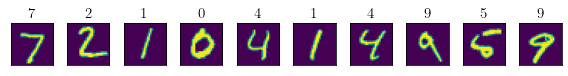

In [19]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
classes_names = np.arange(nsamples)
imgs_test, labels = next(iter(test_loader))
import matplotlib
figure = plt.figure(figsize=(8,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

## Parametring the network

In [20]:
# Using Bernoulli or Multinomial loss
num_classes = 1

# Number of hidden and latent
n_hidden = 512
n_latent = 2

# Compute input dimensionality
nin = imgs_test.shape[2] * imgs_test.shape[3]   #28x28 pixels

# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)

# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)

# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Epoch: 1, Test set ELBO: tensor([19.6594], grad_fn=<AddBackward0>)
KL -10.147026062011719


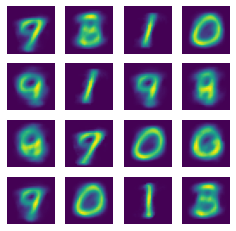

Epoch: 2, Test set ELBO: tensor([18.6585], grad_fn=<AddBackward0>)
KL -10.040752410888672


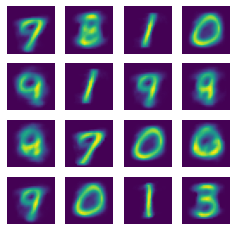

Epoch: 3, Test set ELBO: tensor([18.1356], grad_fn=<AddBackward0>)
KL -9.920759201049805


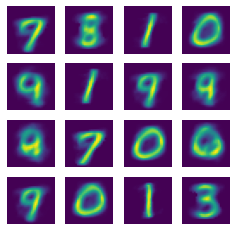

Epoch: 4, Test set ELBO: tensor([17.7690], grad_fn=<AddBackward0>)
KL -9.901537895202637


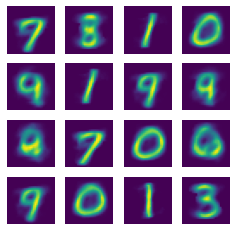

Epoch: 5, Test set ELBO: tensor([17.4853], grad_fn=<AddBackward0>)
KL -9.890594482421875


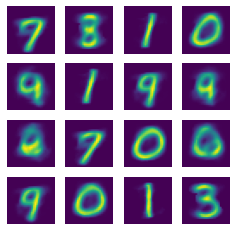

Epoch: 6, Test set ELBO: tensor([17.2718], grad_fn=<AddBackward0>)
KL -9.734537124633789


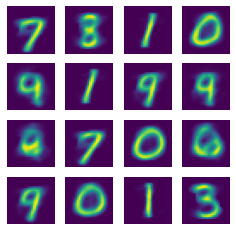

Epoch: 7, Test set ELBO: tensor([17.0712], grad_fn=<AddBackward0>)
KL -9.940692901611328


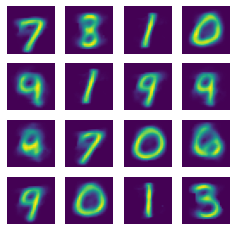

Epoch: 8, Test set ELBO: tensor([16.9124], grad_fn=<AddBackward0>)
KL -9.437865257263184


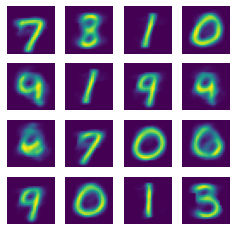

Epoch: 9, Test set ELBO: tensor([16.7578], grad_fn=<AddBackward0>)
KL -9.664501190185547


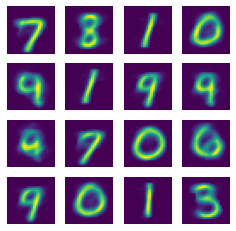

Epoch: 10, Test set ELBO: tensor([16.6428], grad_fn=<AddBackward0>)
KL -9.521244049072266


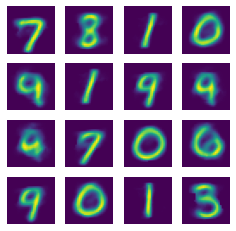

Epoch: 11, Test set ELBO: tensor([16.5077], grad_fn=<AddBackward0>)
KL -9.843979835510254


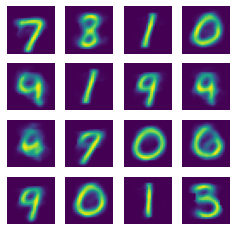

Epoch: 12, Test set ELBO: tensor([16.3918], grad_fn=<AddBackward0>)
KL -9.453765869140625


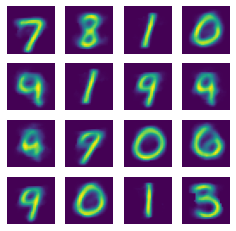

Epoch: 13, Test set ELBO: tensor([16.2798], grad_fn=<AddBackward0>)
KL -9.65172004699707


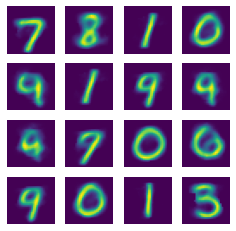

Epoch: 14, Test set ELBO: tensor([16.1810], grad_fn=<AddBackward0>)
KL -10.091535568237305


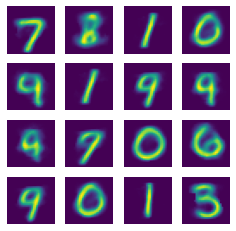

Epoch: 15, Test set ELBO: tensor([16.0722], grad_fn=<AddBackward0>)
KL -9.31132984161377


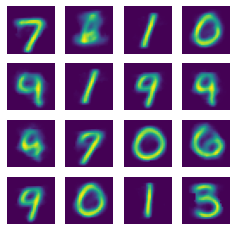

Epoch: 16, Test set ELBO: tensor([16.0051], grad_fn=<AddBackward0>)
KL -9.785118103027344


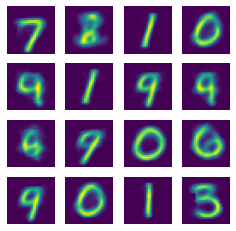

Epoch: 17, Test set ELBO: tensor([15.9181], grad_fn=<AddBackward0>)
KL -9.69162368774414


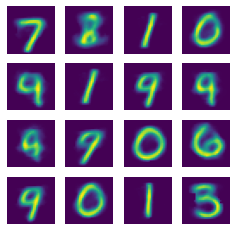

Epoch: 18, Test set ELBO: tensor([15.8285], grad_fn=<AddBackward0>)
KL -9.862302780151367


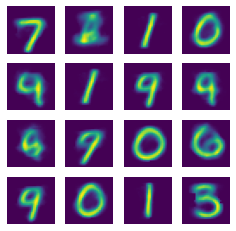

Epoch: 19, Test set ELBO: tensor([15.7493], grad_fn=<AddBackward0>)
KL -9.815390586853027


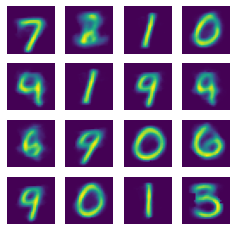

Epoch: 20, Test set ELBO: tensor([15.6892], grad_fn=<AddBackward0>)
KL -9.37740707397461


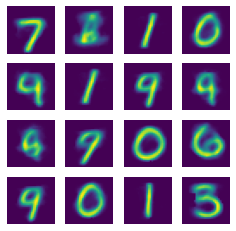

Epoch: 21, Test set ELBO: tensor([15.6320], grad_fn=<AddBackward0>)
KL -9.946748733520508


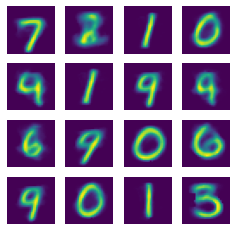

Epoch: 22, Test set ELBO: tensor([15.5588], grad_fn=<AddBackward0>)
KL -9.610862731933594


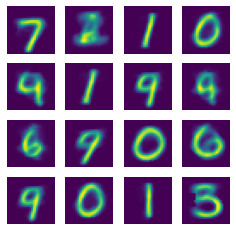

Epoch: 23, Test set ELBO: tensor([15.4971], grad_fn=<AddBackward0>)
KL -10.044652938842773


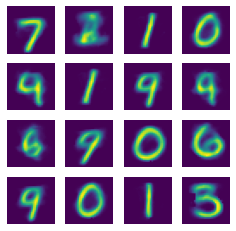

Epoch: 24, Test set ELBO: tensor([15.4480], grad_fn=<AddBackward0>)
KL -9.88665771484375


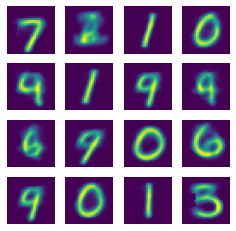

Epoch: 25, Test set ELBO: tensor([15.3954], grad_fn=<AddBackward0>)
KL -9.599128723144531


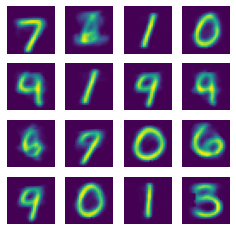

Epoch: 26, Test set ELBO: tensor([15.3213], grad_fn=<AddBackward0>)
KL -9.846376419067383


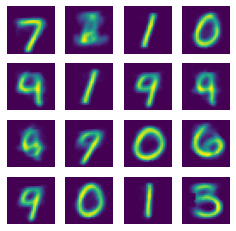

Epoch: 27, Test set ELBO: tensor([15.2689], grad_fn=<AddBackward0>)
KL -9.703296661376953


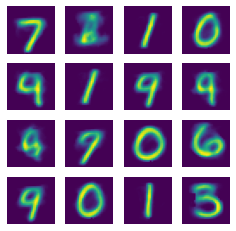

Epoch: 28, Test set ELBO: tensor([15.2253], grad_fn=<AddBackward0>)
KL -10.194379806518555


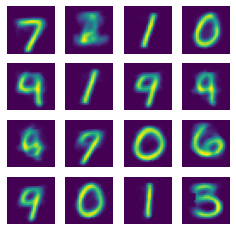

Epoch: 29, Test set ELBO: tensor([15.1914], grad_fn=<AddBackward0>)
KL -9.86268424987793


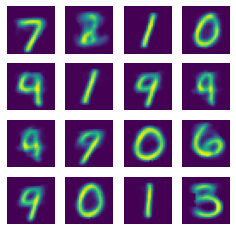

Epoch: 30, Test set ELBO: tensor([15.1313], grad_fn=<AddBackward0>)
KL -10.309080123901367


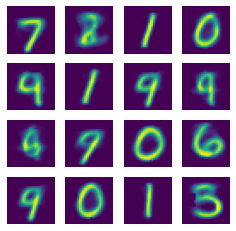

Epoch: 31, Test set ELBO: tensor([15.1050], grad_fn=<AddBackward0>)
KL -10.052230834960938


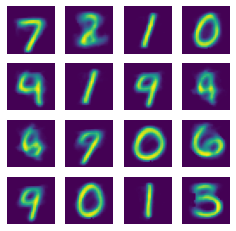

Epoch: 32, Test set ELBO: tensor([15.0567], grad_fn=<AddBackward0>)
KL -9.994985580444336


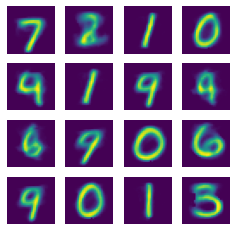

Epoch: 33, Test set ELBO: tensor([15.0380], grad_fn=<AddBackward0>)
KL -9.699359893798828


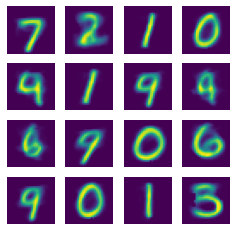

Epoch: 34, Test set ELBO: tensor([14.9635], grad_fn=<AddBackward0>)
KL -9.941644668579102


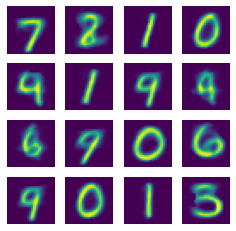

Epoch: 35, Test set ELBO: tensor([14.9245], grad_fn=<AddBackward0>)
KL -9.82311725616455


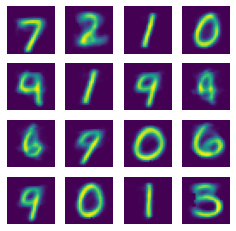

Epoch: 36, Test set ELBO: tensor([14.9348], grad_fn=<AddBackward0>)
KL -10.393424987792969


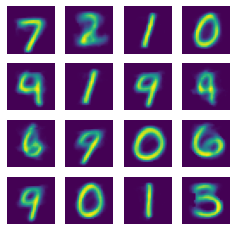

Epoch: 37, Test set ELBO: tensor([14.8406], grad_fn=<AddBackward0>)
KL -10.00704288482666


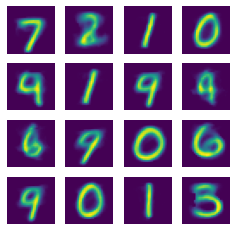

Epoch: 38, Test set ELBO: tensor([14.8341], grad_fn=<AddBackward0>)
KL -10.072093963623047


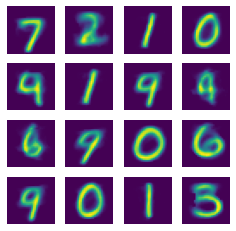

Epoch: 39, Test set ELBO: tensor([14.7888], grad_fn=<AddBackward0>)
KL -9.857277870178223


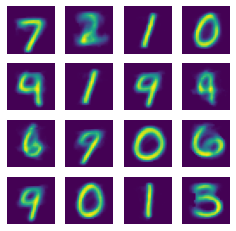

Epoch: 40, Test set ELBO: tensor([14.7563], grad_fn=<AddBackward0>)
KL -10.3130464553833


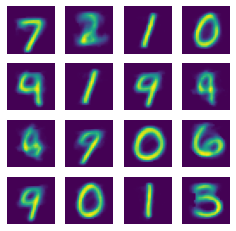

Epoch: 41, Test set ELBO: tensor([14.7220], grad_fn=<AddBackward0>)
KL -9.733250617980957


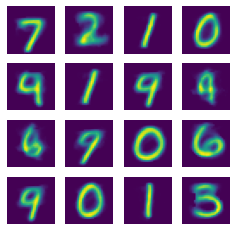

Epoch: 42, Test set ELBO: tensor([14.6750], grad_fn=<AddBackward0>)
KL -10.088891983032227


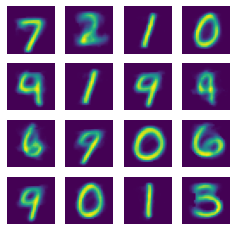

Epoch: 43, Test set ELBO: tensor([14.6601], grad_fn=<AddBackward0>)
KL -9.988421440124512


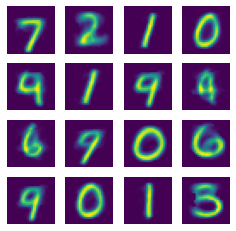

Epoch: 44, Test set ELBO: tensor([14.6267], grad_fn=<AddBackward0>)
KL -10.206707000732422


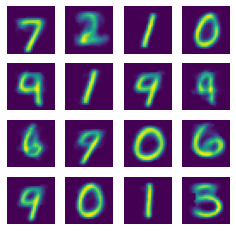

Epoch: 45, Test set ELBO: tensor([14.5888], grad_fn=<AddBackward0>)
KL -10.065707206726074


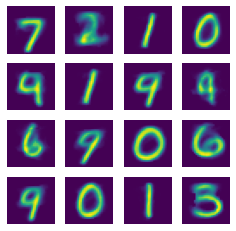

Epoch: 46, Test set ELBO: tensor([14.5628], grad_fn=<AddBackward0>)
KL -10.523149490356445


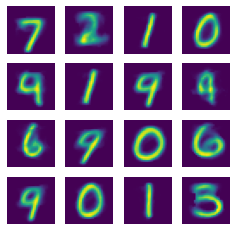

/usr/local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/usr/local/lib/python3.9/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /usr/local/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /usr/local/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
 in /usr/local/lib/python3.9/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extension: {e}")
/usr/local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/usr/local/lib/python3.9/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5

RuntimeError: DataLoader worker (pid(s) 6156, 6157, 6158) exited unexpectedly

In [24]:
def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach(), cmap='viridis')
        plt.axis('off')

    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

learn = True
if learn :
    epochs=50
    test_sample = imgs_test[0:16, :, :, :]
    for epoch in range(1, epochs + 1):
        full_loss = torch.Tensor([0])
        
        # Forward pass: compute predicted y by passing x to the model.
        for i, (x, _) in enumerate(train_loader):
            # Compute the loss.
            loss, kl_div = compute_loss(model, x,beta=1e-4)

            # Before the backward pass, zero all of the network gradients
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to parameters
            loss.backward()
            
            # Calling the step function to update the parameters
            optimizer.step()
            full_loss += loss

        #TO CHECK THE LEARNING    
        #for i, (x, _) in enumerate(valid_loader):
        #    train_step(model, x, optimizer)

        print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))
        print(f"KL {kl_div}")
        generate_and_save_images(model, epoch, test_sample)

    #SAVING...
    PATH = "VAE_MNIST_model"
    #torch.save(model.state_dict(), PATH)
    torch.save(model, PATH)
else :
    model = torch.load("VAE_MNIST_model")

## Sampling from latent space

tensor([-0.5386,  1.1917])


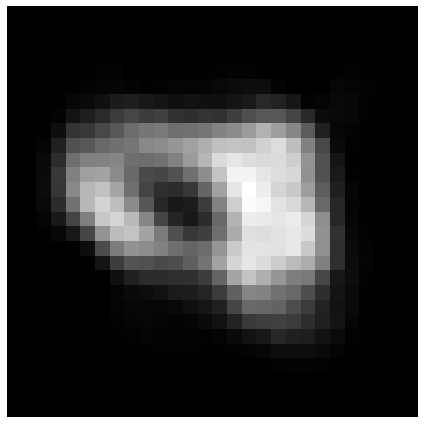

In [78]:
z_test = torch.randn(n_latent) #choose a random latent vector
print(z_test)
z_out = model.decode(z_test).reshape((1,28,28))

fig = plt.figure(figsize=(13,6))
ax1 = fig.add_subplot(111)

img = ax1.imshow(z_out.detach().numpy().T,
    cmap="gray" ,
    interpolation = "none",
    origin="lower")

plt.axis("off")

ax1.set_xlabel("")
ax1.set_ylabel(r"")
ax1.set_title(r"")

fig.tight_layout()

(100, 2)


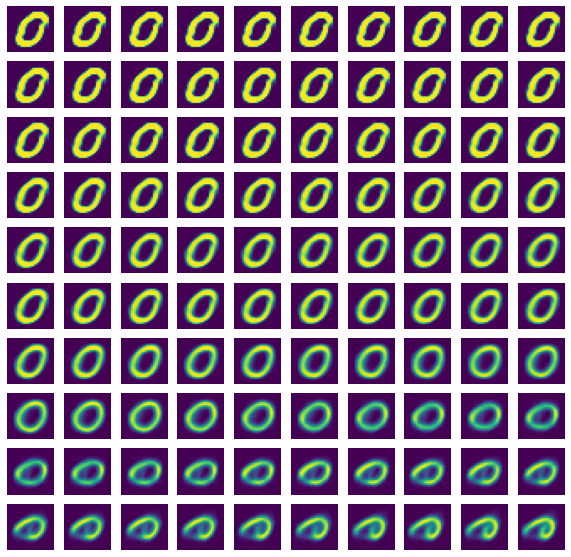

In [106]:
latent_range = 1
n_prop = 100

z_test0 = torch.randn(n_latent).numpy()
z_tests = np.concatenate((np.linspace(z_test0[0]-latent_range,z_test0[0]+latent_range,n_prop),np.linspace(z_test0[1]-latent_range,z_test0[1]+latent_range,n_prop))).reshape((n_prop,len(z_test0)))

print(z_tests.shape)

z_tests = torch.from_numpy(z_tests)
z_tests = z_tests.to(dtype=torch.float32)

z_out = np.zeros((n_prop,1,28,28))
for i in range(z_out.shape[0]):
    z_out[i] = model.decode(z_tests[i,:]).detach().numpy().reshape((1,28,28))


fig = plt.figure(figsize=(10, 10))
for i in range(z_out.shape[0]):
    plt.subplot(int(np.sqrt(n_prop)), int(np.sqrt(n_prop)), i + 1)
    #z_out[i,:,0,:] = 0.1*i*np.ones(z_out.shape[-1])
    plt.imshow((z_out[i]).T, cmap='viridis')
    plt.axis('off')

plt.show()

- Les (0:4x10) premières figures traduisent le déplacement sur le premier axe de l'espace latent, à partir de l'image (1,1).
- Les (5:10X10) autres figures traduisent le déplacement sur l'autre axe de l'espace latent, toujours à partir de l'image (1,1).

# Implementing an MMD divergence

In [167]:
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
        
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

def construct_encoder_decoder_complex(nin, n_latent = 16, n_hidden = 64, n_params = 0, n_classes = 1):        
    # Encoder network
    encoder = nn.Sequential(
        nn.Conv2d(nin, n_hidden, 4, 2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(n_hidden, 2 * n_hidden, 4, 2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Flatten(),
        nn.Linear(2 * n_hidden*7*7, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, n_latent)
    )
    
    # Decoder network
    decoder = nn.Sequential(
        torch.nn.Linear(n_latent, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 7 * 7 * 2*n_hidden),
        torch.nn.ReLU(),
        Reshape((128,7,7,)),
        torch.nn.ConvTranspose2d(2 * n_hidden, n_hidden, 4, 2, padding=1),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(n_hidden, nin * n_classes, 4, 2, padding=1),
        torch.nn.Sigmoid() # pour la MSE loss
        # torch.nn.Softmax() # pour la multinomail loss
    )
    return encoder, decoder

In [172]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(nin, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )
    
    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid()
    )
    return encoder, decoder

In [173]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    
    tiled_x = x.view(x_size, 1, dim).repeat(1, y_size, 1)
    tiled_y = y.view(1, y_size, dim).repeat(x_size, 1, 1)
    
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) / float(dim)
    return torch.exp(-kernel_input)


def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return torch.mean(x_kernel) + torch.mean(y_kernel) - 2*torch.mean(xy_kernel)


class InfoVAEMMD(VAE):
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(InfoVAEMMD, self).__init__(encoder, decoder, encoding_dims, latent_dims)
        
    def encode(self, x):
        z = self.encoder(x)
        return z
            
    def forward(self, x):
        # Encode the inputs
        z = self.encode(x)
        
        # Obtain latent samples and latent loss
        z_params, mmd = self.latent(x, z)

        # Decode the samples
        x_tilde = self.decode(z_params)
        return x_tilde.reshape(-1, 1, 28, 28), mmd    
    
    def latent(self, x, z_params):
        true_samples = torch.randn(len(x),n_latent)
        mmd = compute_mmd(true_samples, z_params)
        return z_params, mmd

In [184]:
# Size of latent space
n_latent = 16
#n_latent = 2

# Number of hidden units
n_hidden = 64
#n_hidden = 512

# Rely on Bernoulli or multinomial
num_classes = 1

# Number of input channels
nin = 1
#nin = imgs_test.shape[2] * imgs_test.shape[3]   #28x28 pixels

# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder_complex(nin = nin, n_latent = n_latent, n_hidden = n_hidden, n_params = 0, n_classes = num_classes)
#encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)

# Create VAE or (InfoVAEMMD - WAE) model
model_flow_p = InfoVAEMMD(encoder, decoder, n_hidden, n_latent)

# Create optimizer algorithm
optimizer_flow_p = torch.optim.Adam(model_flow_p.parameters(), lr=1e-4)
recons_criterion = torch.nn.MSELoss(reduction='sum')
# recons_criterion = torch.nn.BCELoss(reduction='sum')

# Add learning rate scheduler
# scheduler = ...

In [185]:
def compute_loss_flow(model, x):
    
    # regularization donnée ici: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    l = 500
    
    y_pred, mmd = model(x)
    recons_loss = recons_criterion(y_pred, x)
    
    full_loss = recons_loss + mmd * l
    return full_loss

In [186]:
# Launch our optimization
epochs=50
test_sample = imgs_test[0:16, :, :, :]
losses_flow = []

for epoch in range(1, epochs + 1):
    full_loss_flow = 0

    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):

        # forward the model
        y_pred, mmd = model_flow_p(x)
    
        # compute loss
        loss_flow = compute_loss_flow(model_flow_p, x)
    
        # Before the backward pass, zero all of the network gradients
        optimizer_flow_p.zero_grad()
   
        # Backward pass: compute gradient of the loss with respect to parameters
        loss_flow.backward()
    
        # Calling the step function to update the parameters
        optimizer_flow_p.step()

    print('Epoch: {}, Test set ELBO: {}'.format(epoch, loss_flow))
    losses_flow.append(loss_flow.detach().cpu().numpy())
    generate_and_save_images(model_flow_p, epoch, test_sample)

KeyboardInterrupt: 